#### library

In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import sys
from datetime import datetime, timedelta
from geopy.distance import great_circle

from sklearn.neighbors import KDTree, BallTree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
import optuna
import catboost as cb

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

utils_directory = os.path.abspath('..')
sys.path.append(utils_directory)

import preprocessing

from utils.constant_utils import Directory
from utils import common_utils
from models.SpatialWeightMatrix import SpatialWeightMatrix
from models.XGBoostWithSpatialWeight import XGBoostWithSpatialWeight


import model
from inference import *

features_directory = os.path.abspath('../features')
sys.path.append(features_directory)

from clustering_features import *
from count_features import *
from distance_features import *
from other_features import *
from deposit_features import *

/data/ephemeral/home/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### data load

In [ ]:
print("Start the main.py successfully!")

'''
name : 실험자 이름입니다.
title : result 폴더에 저장될 실험명을 지정합니다.
'''
name = 'eun'
title = 'cluster,timefeature,categorical,drop,gangnam,xgb1000'

print("total data load ...")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)

Start the main.py successfully!
total data load ...


##### fe

In [3]:
### 클러스터 피처 apply
print("clustering apply ...")
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(df, info_df, feat_name=info_df_name, n_clusters=20)

### 이상치 처리
print("start to cleaning outliers...")
df = preprocessing.handle_age_outliers(df)

### 데이터 분할
print("train, valid, test split for preprocessing & feature engineering ...")
train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)


### 데이터 전처리
print("start to preprocessing...")
# type 카테고리화
train_data_ = preprocessing.numeric_to_categoric(train_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
valid_data_ = preprocessing.numeric_to_categoric(valid_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
test_data_ = preprocessing.numeric_to_categoric(test_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})

# 중복 제거
train_data_ = preprocessing.handle_duplicates(train_data_)
valid_data_ = preprocessing.handle_duplicates(valid_data_)

clustering apply ...


start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...


In [4]:
### 피처 엔지니어링
print("start to feature engineering...")
# clustering_feature
print("create clustering features")
train_data, valid_data, test_data = create_clustering_target(train_data_, valid_data_, test_data_)
train_data, valid_data, test_data = create_cluster_deposit_median(train_data, valid_data, test_data)

# distance_features

print("create distance features")
train_data, valid_data, test_data = distance_gangnam(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_school_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = weighted_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)

# other_features
print("create other features")
train_data, valid_data, test_data = create_temporal_feature(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sin_cos_season(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_floor_area_interaction(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sum_park_area_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = shift_interest_rate_function(train_data, valid_data, test_data)
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'age')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'floor')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'area_m2')

# count_features
print("create count features")
train_data, valid_data, test_data = transaction_count_function(train_data, valid_data, test_data)
# 위의 함수를 바로 실행하기 위한 구조 : data/transaction_data에 train/valid/test_transaction_{month}.txt 구조의 파일이 있어야함
train_data, valid_data, test_data = create_subway_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_counts_within_radius_by_school_level(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_place_within_radius(train_data, valid_data, test_data)

start to feature engineering...
create clustering features
create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.


In [5]:
## deposit feature
print("create deposit feature 1")
train_data_dep, valid_data_dep = add_recent_rent_in_building(train_data, valid_data, type = 'valid')
print("create deposit feature 2")
train_data_dep, valid_data_dep = add_avg_rent_in_past_year(train_data_dep, valid_data_dep, type = 'valid')
print("create deposit feature 3")
train_data_dep, valid_data_dep = add_rent_growth_rate(train_data_dep, valid_data_dep, type = 'valid')

create deposit feature 1


create deposit feature 2
create deposit feature 3


In [6]:
exclude_cols = ['type', 'deposit']

    # 스케일링할 수치형 변수 선택
features_to_scale = [col for col in train_data_dep.columns 
                    if col not in exclude_cols and train_data_dep[col].dtype in ['int64', 'float64']]

In [7]:
### 정규화
print("standardization...")

    # 스케일링할 수치형 변수 선택
features_to_scale = [col for col in train_data_dep.columns 
                    if col not in exclude_cols and train_data_dep[col].dtype in ['int64', 'float64']]

scaler = StandardScaler()

train_data_scaled = train_data_dep.copy()
train_data_scaled[features_to_scale] = scaler.fit_transform(train_data_dep[features_to_scale])

valid_data_scaled = valid_data_dep.copy()
valid_data_scaled[features_to_scale] = scaler.transform(valid_data_dep[features_to_scale])

# feature selection
# train_data, valid_data, test_data = preprocessing.feature_selection(train_data, valid_data, test_data)

standardization...


In [8]:
drop_columns = ['type', 'season', 'date']
train_data_scaled.drop(drop_columns, axis = 1, inplace = True)
valid_data_scaled.drop(drop_columns, axis = 1, inplace = True)

In [10]:
X_train = train_data_scaled.drop(columns=['deposit'])
y_train = train_data_scaled['deposit']
X_valid = valid_data_scaled.drop(columns=['deposit'])
y_valid = valid_data_scaled['deposit']

validation Mae score
4661.572507896596


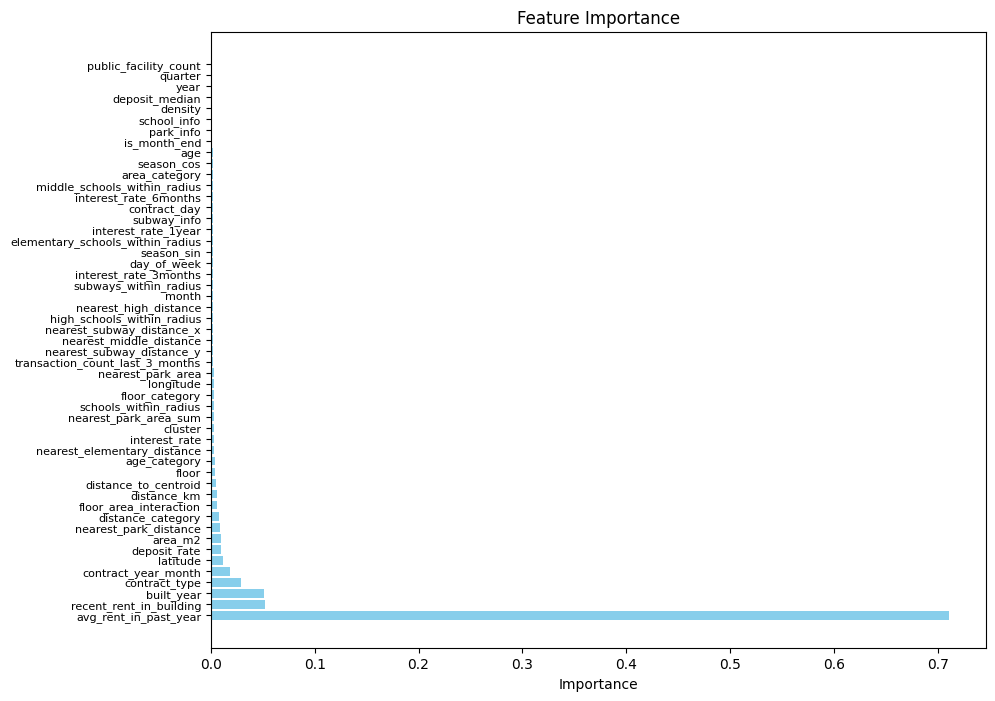

In [11]:
model_ = model.xgboost(X_train, y_train)
prediction, mae = inference(model_, 'validation', X_valid, y_valid)

# Feature importance 추출
importance = model_.feature_importances_

# Feature importance를 DataFrame으로 변환
train_df = train_data_scaled.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Feature importance 시각화
plt.figure(figsize=(10,8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.yticks(fontsize=8)
plt.title('Feature Importance')
plt.show()

In [12]:
#### 상위 n개에 대한 데이터만 실험
top_n_features = list(importance_df.head(20)['Feature'].values)
top_n_features

['avg_rent_in_past_year',
 'recent_rent_in_building',
 'built_year',
 'contract_type',
 'contract_year_month',
 'latitude',
 'deposit_rate',
 'area_m2',
 'nearest_park_distance',
 'distance_category',
 'floor_area_interaction',
 'distance_km',
 'distance_to_centroid',
 'floor',
 'age_category',
 'nearest_elementary_distance',
 'interest_rate',
 'cluster',
 'nearest_park_area_sum',
 'schools_within_radius']

In [21]:
## deposit feature
total_train_data = pd.concat([train_data, valid_data])

print("create deposit feature 1")
total_train_data_dep, test_data_dep = add_recent_rent_in_building(total_train_data, test_data, type = 'test')
print(total_train_data_dep.shape,test_data_dep.shape)
print("create deposit feature 2")
total_train_data_dep, test_data_dep = add_avg_rent_in_past_year(total_train_data_dep, test_data_dep, type = 'test')
print(test_data_dep.shape)
print("create deposit feature 3")
total_train_data_dep, test_data_dep = add_rent_growth_rate(total_train_data_dep, test_data_dep, type = 'test')
print(test_data_dep.shape)

create deposit feature 1
(1714416, 53) (150172, 53)
create deposit feature 2
(150172, 54)
create deposit feature 3
(150172, 55)


In [26]:
feat = top_n_features[1:] + ['longitude','deposit']

total_train_data_dep = total_train_data_dep[feat]
test_data_dep = test_data_dep[feat]

In [27]:
### 정규화
print("standardization...")

exclude_cols = ['deposit']

# 스케일링할 수치형 변수 선택
features_to_scale = [col for col in total_train_data_dep.columns 
                    if col not in exclude_cols and total_train_data_dep[col].dtype in ['int64', 'float64']]

scaler = StandardScaler()

total_train_data_scaled = total_train_data_dep.copy()
total_train_data_scaled[features_to_scale] = scaler.fit_transform(total_train_data_dep[features_to_scale])

test_data_scaled = test_data_dep.copy()
test_data_scaled[features_to_scale] = scaler.transform(test_data_dep[features_to_scale])

# feature selection
# train_data, valid_data, test_data = preprocessing.feature_selection(train_data, valid_data, test_data)

standardization...


In [28]:
 # train with total dataset
print("Training with total dataset...")

spatial_weight_matrix = SpatialWeightMatrix()
spatial_weight_matrix.generate_weight_matrices(total_train_data_scaled, total_train_data_scaled, dataset_type='train_total')
spatial_weight_matrix.generate_weight_matrices(test_data_scaled, total_train_data_scaled, dataset_type='test')

model = XGBoostWithSpatialWeight(spatial_weight_matrix)
model.train(total_train_data_scaled, dataset_type='train_total')

Training with total dataset...


In [29]:
sample_submission = Directory.sample_submission
sample_submission['deposit'] = model.inference(test_data_scaled, total_train_data_scaled)
# save sample submission
# save sample submission
submission_path = os.path.join("/data/ephemeral/home/level2-competitiveds-recsys-01/result", "submission")
os.makedirs(submission_path, exist_ok=True)

submission_file_path = os.path.join(submission_path, 'plus deposit features(drop years) and feature20+weighted matrix+version3+ xgboost')
sample_submission.to_csv(submission_file_path, index=False, encoding='utf-8-sig')

print("Successfully executed main.py.")

Successfully executed main.py.
